## Data Preprocessing

In [1]:
from statsmodels.tsa.stattools import coint
from tempdisagg import TempDisaggModel
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('Data/Macro.csv')
data['Exports_numeric'] = pd.to_numeric(data['Exports'], errors='coerce')
data['Imports_numeric'] = pd.to_numeric(data['Imports'], errors='coerce')
data['USDPHP_numeric'] = pd.to_numeric(data['USDPHP'], errors='coerce')

data['Monthly_Trade_PHP'] = (
    data['Exports_numeric'] + data['Imports_numeric']
) * data['USDPHP_numeric']

# Create quarterly trade by summing 3 months
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + 
                             data['Month'].astype(str) + '-01')
data.set_index('Date', inplace=True)

# Resample to quarterly sum
quarterly_trade = data['Monthly_Trade_PHP'].resample('QE').sum()

# Get quarterly GDP (remove NaNs)
quarterly_gdp = data['Nominal GDP'].resample('QE').mean().dropna()

# Align both series on common dates
start, end = "1991-01-01", "2004-12-31"

gdp_series = quarterly_gdp.loc[start:end]
trade_series = quarterly_trade.loc[start:end]

# Test for cointegration
coint(gdp_series, trade_series, autolag='AIC')


(np.float64(-2.3757208699955488),
 np.float64(0.3364386725432962),
 array([-4.10664876, -3.44947826, -3.1224619 ]))

In [52]:
from disaggregation import main
subset = main() 
subset.head()

Disaggregated CSV exists. Loading...


,Unnamed: 3,Inflation,Population,GDP,Imports,Exports,Agriculture,Industry,Services,USDPHP,Nominal GDP,TotalTrade,TotalTrade_PHPMN,NominalGDP_disagg,Pop_disagg
0,1/1/1992,10.9,NaN,NaN,1037.69,662.37,NaN,NaN,NaN,26.5446,NaN,1700.06,45127.41268,136347.8527,63004203.31
1,2/1/1992,9.1,NaN,NaN,1032.51,714.90,NaN,NaN,NaN,26.1580,NaN,1747.41,45708.75078,137765.5289,62965193.58
2,3/1/1992,8.7,NaN,1244652.42,1164.81,898.46,18.11,32.58,49.3,25.8102,362800.0,2063.27,53253.41135,128415.5503,62929730.18
3,4/1/1992,8.4,NaN,NaN,1196.81,666.45,NaN,NaN,NaN,25.6672,NaN,1863.26,47824.66707,120089.5621,62897813.13
4,5/1/1992,8.9,NaN,NaN,1186.29,811.71,NaN,NaN,NaN,26.1496,NaN,1998.00,52246.90080,124258.7011,62869442.41


In [53]:
!python disaggregation.py

Disaggregated CSV exists. Loading...


## Model Building

for testing/reference only

actual code already in separate scripts, go straight to tuning to use

In [1]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from sklearn.model_selection import TimeSeriesSplit

import random

import os
import json


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.X) - self.seq_len 
        
    def __getitem__(self, idx):
        return (self.X[idx:idx+self.seq_len], self.y[idx+self.seq_len])

In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.2):
        super(GRUModel, self).__init__()
        
        # GRU layer
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0  # Changed from dropout to 0
        )
        
        # Add manual dropout layer
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.dropout(out)  # Apply dropout manually here
        out = self.fc(out)
        return out

In [4]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
    def forward(self, predictions, targets):       
        return torch.sqrt(self.mse(predictions, targets) + 1e-6)
        
class MAPELoss(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(MAPELoss, self).__init__()
        self.epsilon = epsilon  # Small constant to prevent division by zero

    def forward(self, output, target):
        return torch.mean(torch.abs((target - output) / (target + self.epsilon)))*100

In [5]:
class Arguments:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [6]:
def set_seed(seed=None):
    if seed is None:
        seed = 1
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Remove CUDA-specific settings for Mac
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    
    # MPS doesn't need special deterministic settings
    os.environ['PYTHONHASHSEED'] = str(seed)

In [7]:
def split_data(X, use_val=True):
    if use_val:
        train_size = int(0.6 * len(X))
        val_size = int(0.2 * len(X))

        train = X[:train_size]
        val = X[train_size:train_size + val_size]
        test = X[train_size + val_size:]

        return train, val, test

In [8]:
from sklearn.preprocessing import MinMaxScaler
import pickle

def transform_data(data, save_path="Transforms/scaler.pkl"):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    with open(save_path, "wb") as f:
        pickle.dump(scaler, f)
    
    return data_scaled

def inverse_transform(data, load_path="Transforms/scaler.pkl"):
    with open(load_path, "rb") as f:
        scaler = pickle.load(f)
    return scaler.inverse_transform(data)

In [9]:
def train_model(model, dataloader, device, optimizer, criterion):

    model.train()
    total_loss = 0.0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

    return total_loss / total_samples if total_samples > 0 else 0.0

@torch.no_grad()
def evaluate(model, dataloader, device, criterion, args):

    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)


        outputs = model(inputs)
        loss = criterion(outputs, targets)

        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)
        all_preds.append(outputs.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0

    return avg_loss, all_preds

In [ ]:
def run(model, train_loader, val_loader, test_loader, args, fold=None):
    
    set_seed(args.seed if hasattr(args, 'seed') else 1)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        factor=args.factor, 
        patience=args.patience
    )
    
    train_losses = []
    val_losses = []

    for e in range(args.epoch):
        train_loss = train_model(model, train_loader, args.device, optimizer, args.train_criterion)
        val_loss, _ = evaluate(model, val_loader, args.device, args.train_criterion, args)
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (e + 1) % 100 == 0 or e == 0:
            fold_prefix = f"Fold {fold} - " if fold is not None else ""
            print(f"{fold_prefix}Epoch {e+1}/{args.epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    _, test_preds = evaluate(model, test_loader, args.device, args.test_criterion, args)

    # Inverse transform 
    if fold is not None:
        scaler_name = f"Transforms/labels_scaled{fold}"
    else:
        scaler_name =f"Transforms/labels_scaled"
    
    inversed_test_preds = inverse_transform(test_preds, scaler_name)
    
    # Get corresponding actual labels from test_loader 
    actual_labels = []
    for _, targets in test_loader:
        actual_labels.append(targets)
    actual_labels = torch.cat(actual_labels, dim=0).cpu().numpy()
    
    # Inverse transform actual labels 
    inversed_actual = inverse_transform(actual_labels, scaler_name)
    
    # Calculate test loss
    test_loss = args.test_criterion(
        torch.tensor(inversed_test_preds), 
        torch.tensor(inversed_actual)
    )
    
    return test_loss, inversed_test_preds, train_losses, val_losses

In [ ]:
def crossval(data, labels, test_data, test_labels, args, n_splits=5):
        
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(data)):
        print(f"\n{'='*50}")
        print(f"Fold {fold + 1}/{n_splits}")
        print(f"{'='*50}")
        
        # Split data for this fold
        train_data_fold = data[train_idx]
        train_labels_fold = labels[train_idx]
        val_data_fold = data[val_idx]
        val_labels_fold = labels[val_idx]
        
        # Scale data
        set_seed(1)
        train_data_scaled = transform_data(train_data_fold, f"Transforms/train_scaled_{fold}")
        train_labels_scaled = transform_data(train_labels_fold, f"Transforms/labels_scaled{fold}")
        val_data_scaled = transform_data(val_data_fold, f"Transforms/train_scaled_{fold}")
        val_labels_scaled = transform_data(val_labels_fold, f"Transforms/labels_scaled{fold}")
        test_data_scaled = transform_data(test_data, f"Transforms/train_scaled_{fold}")
        test_labels_scaled = transform_data(test_labels, f"Transforms/labels_scaled{fold}")
        
        input_size = train_data_scaled.shape[1]
        output_size = train_labels_scaled.shape[1]
        
        # Create datasets
        train_dataset = TimeSeriesDataset(train_data_scaled, train_labels_scaled, seq_len=args.seq_len)
        val_dataset = TimeSeriesDataset(val_data_scaled, val_labels_scaled, seq_len=args.seq_len)
        test_dataset = TimeSeriesDataset(test_data_scaled, test_labels_scaled, seq_len=args.seq_len)
        
        # Create loaders
        train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
        
        # Create fresh model for this fold
        set_seed(1)
        model = GRUModel(
            input_size=input_size,
            hidden_size=args.hidden_size,
            output_size=output_size,
            num_layers=args.num_layers,
            dropout=args.dropout
        ).to(args.device)
        
        # Pass fold number to run function
        test_loss, test_preds, train_losses, val_losses = run(
            model, 
            train_loader, 
            val_loader, 
            test_loader, 
            args,
            fold=fold  # Pass fold number
        )
        
        # Store results
        fold_results.append({
            'fold': fold + 1,
            'test_loss': test_loss.item() if torch.is_tensor(test_loss) else test_loss,
            'test_preds': test_preds,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_size': len(train_idx),
            'val_size': len(val_idx)
        })
        
        print(f"Fold {fold + 1} Test Loss: {test_loss:.4f}")
    
    # Summary statistics
    test_losses = [r['test_loss'] for r in fold_results]
    print(f"\n{'='*50}")
    print(f"Cross-Validation Results:")
    print(f"{'='*50}")
    print(f"Mean Test Loss: {np.mean(test_losses):.4f} (+/- {np.std(test_losses):.4f})")
    print(f"Min Test Loss: {np.min(test_losses):.4f}")
    print(f"Max Test Loss: {np.max(test_losses):.4f}")
    
    return fold_results

In [12]:
def load_dataset(args):
    """Load and prepare all datasets"""
    
    # Load raw data files
    btr_data = pd.read_csv("Data/cordata.csv")
    btr_data = btr_data.set_index("Date")

    macro_data = pd.read_csv("Data/disaggregated.csv")
    macro_data = macro_data.rename(columns={'Unnamed: 3': 'Date'}).set_index('Date')
    macro_data = macro_data[['TotalTrade_PHPMN', 'NominalGDP_disagg', 'Pop_disagg']]

    dummy = pd.read_csv("Data/dummy.csv").fillna(0)
    dummy = dummy.set_index("Date")

    # Convert to datetime
    btr_data.index = pd.to_datetime(btr_data.index)
    macro_data.index = pd.to_datetime(macro_data.index)
    dummy.index = pd.to_datetime(dummy.index)

    # Keep Jan 1992 onwards
    start = "1992-01-01"
    btr_data = btr_data.loc[start:]
    macro_data = macro_data.loc[start:]
    dummy = dummy.loc[start:]

    # Join data
    df = btr_data.join(macro_data, how="inner").join(dummy, how="inner")

    # Create X and y
    X = pd.concat(
        [btr_data[['BIR', 'BOC', 'Other Offices']], macro_data, dummy],
        axis=1
    ).values.copy()
    y = df[['BIR', 'BOC', 'Other Offices']].values.copy()

    # Split into train/val/test
    train_data, val_data, test_data = split_data(X)
    train_labels, val_labels, test_labels = split_data(y)
    
    # Combine train + val for cross-validation
    cv_data = np.concatenate([train_data, val_data], axis=0)
    cv_labels = np.concatenate([train_labels, val_labels], axis=0)

    # Return everything needed
    return {
        'cv_data': cv_data,
        'cv_labels': cv_labels,
        'test_data': test_data,
        'test_labels': test_labels,
        'input_size': cv_data.shape[1],
        'output_size': cv_labels.shape[1]
    }

In [ ]:
with open("config.json", "r") as f:
    config = json.load(f)

args = Arguments(**config)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device = device

# Add criterions
args.train_criterion = nn.MSELoss()
args.test_criterion = MAPELoss()

# Load dataset
dataset = load_dataset(None)

# Add dataset to args
args.cv_data = dataset['cv_data']
args.cv_labels = dataset['cv_labels']
args.test_data = dataset['test_data']
args.test_labels = dataset['test_labels']
args.input_size = dataset['input_size']
args.output_size = dataset['output_size']

# Set seed
set_seed(args.seed)

# Run cross-validation

fold_results = crossval(
    data=args.cv_data,
    labels=args.cv_labels,
    args=args,
    n_splits=5
)

# Summary
test_losses = [r['test_loss'] for r in fold_results]
print(f"\n{'='*50}")
print(f"Cross-Validation Results:")
print(f"{'='*50}")
print(f"Mean Test Loss: {np.mean(test_losses):.4f} (+/- {np.std(test_losses):.4f})")
print(f"Min Test Loss: {np.min(test_losses):.4f}")
print(f"Max Test Loss: {np.max(test_losses):.4f}")

Running 5-fold cross-validation...

Fold 1/5
Fold 0 - Epoch 1/200 - Train Loss: 0.2552, Val Loss: 0.0550
Fold 0 - Epoch 100/200 - Train Loss: 0.0365, Val Loss: 0.0585
Fold 0 - Epoch 200/200 - Train Loss: 0.0389, Val Loss: 0.0585
Fold 1 Test Loss: 38.2783

Fold 2/5
Fold 1 - Epoch 1/200 - Train Loss: 0.0882, Val Loss: 0.0536
Fold 1 - Epoch 100/200 - Train Loss: 0.0254, Val Loss: 0.0627
Fold 1 - Epoch 200/200 - Train Loss: 0.0249, Val Loss: 0.0627
Fold 2 Test Loss: 23.8141

Fold 3/5
Fold 2 - Epoch 1/200 - Train Loss: 0.0541, Val Loss: 0.0799
Fold 2 - Epoch 100/200 - Train Loss: 0.0189, Val Loss: 0.0467
Fold 2 - Epoch 200/200 - Train Loss: 0.0149, Val Loss: 0.0420
Fold 3 Test Loss: 24.9076

Fold 4/5
Fold 3 - Epoch 1/200 - Train Loss: 0.0327, Val Loss: 0.1517
Fold 3 - Epoch 100/200 - Train Loss: 0.0078, Val Loss: 0.0522
Fold 3 - Epoch 200/200 - Train Loss: 0.0081, Val Loss: 0.0522
Fold 4 Test Loss: 22.8305

Fold 5/5
Fold 4 - Epoch 1/200 - Train Loss: 0.0339, Val Loss: 0.1590
Fold 4 - Epoch 

In [ ]:
with open("config.json", "r") as f:
    config = json.load(f)

args = Arguments(
    **config, 
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device = device

# Load dataset
dataset = load_dataset(None)

set_seed(1)

# Split cv_data into train/val one more time
train_size = int(0.85 * len(dataset['cv_data']))
final_train_data = dataset['cv_data'][:train_size]
final_train_labels = dataset['cv_labels'][:train_size]
final_val_data = dataset['cv_data'][train_size:]
final_val_labels = dataset['cv_labels'][train_size:]

# Scale data
final_train_scaled = transform_data(final_train_data, "Transforms/final_train_scaled")
final_train_labels_scaled = transform_data(final_train_labels, "Transforms/final_labels_scaled")
final_val_scaled = transform_data(final_val_data, "Transforms/final_train_scaled")
final_val_labels_scaled = transform_data(final_val_labels, "Transforms/final_labels_scaled")
final_test_scaled = transform_data(dataset['test_data'], "Transforms/final_train_scaled")
final_test_labels_scaled = transform_data(dataset['test_labels'], "Transforms/final_labels_scaled")

# Create datasets
train_dataset = TimeSeriesDataset(final_train_scaled, final_train_labels_scaled, seq_len=args.seq_len)
val_dataset = TimeSeriesDataset(final_val_scaled, final_val_labels_scaled, seq_len=args.seq_len)
test_dataset = TimeSeriesDataset(final_test_scaled, final_test_labels_scaled, seq_len=args.seq_len)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

set_seed(1)
final_model = GRUModel(
    input_size=dataset['input_size'],
    hidden_size=args.hidden_size,
    output_size=dataset['output_size'],
    num_layers=args.num_layers,
    dropout=args.dropout
).to(device)

args.train_criterion = nn.MSELoss()
args.test_criterion = MAPELoss()

# Train and evaluate
test_loss, test_preds, train_losses, val_losses = run(
    final_model,
    train_loader,
    val_loader,
    test_loader,
    args,
    fold=None  # Not cross-validation
)

print(f"\n{'='*50}")
print(f"Final Model Results:")
print(f"{'='*50}")
print(f"Final Test Loss (MAPE): {test_loss:.4f}%")

## Tuning

In [1]:
import os
os.environ['RAY_AIR_NEW_OUTPUT'] = '0' 

from ray import tune
from ray.tune import RunConfig
from ray.tune import Tuner
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune import CLIReporter

import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np 
import pandas as pd

import train as tr
from model import GRUModel
from data import transform_data, TimeSeriesDataset, inverse_transform
from tuning import ray_train
import utils

import ray

In [2]:
ray.shutdown()
ray.init(
    num_cpus=16,
    num_gpus=1,
    dashboard_host="0.0.0.0",  # Make dashboard accessible
    include_dashboard=True,     # Explicitly enable dashboard
    ignore_reinit_error=True
)

2026-02-18 07:45:36,197	INFO worker.py:1998 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
c:\Anaconda\envs\capsenv\Lib\site-packages\ray\_private\worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


Python version:,3.12.12
Ray version:,2.53.0
Dashboard:,http://127.0.0.1:8265


Run tuning

In [3]:
# ============================================================
# EXPERIMENT LOOP — 2 Targets × 4 Feature Configurations
# ============================================================

trials = 100

reporter = CLIReporter(
    metric="loss",
    mode="min",
    metric_columns=["loss", "std"],
    max_progress_rows=15,
    print_intermediate_tables=True,
    max_report_frequency=30,
    sort_by_metric=True
)

def trial_dirname_creator(trial):
    return f"trial_{trial.trial_id}"

# ---------- Target Definitions ----------
TARGETS = {
    #"aggregated": {
    #    "features": ["Non-tax Revenues", "Expenditures","Tax Revenues", "TotalTrade_PHPMN", "NominalGDP_disagg", "Pop_disagg"],
    #    "labels":   ["Tax Revenues","Non-tax Revenues", "Expenditures"],
        # BIR+BOC+Others collapsed into one "Tax Revenues" column in your cordata.csv
        # If you have an aggregated tax col, add it to features/labels above
   # },
    "disaggregated": {
        "features": ["BIR", "BOC", "Other Offices", "Non-tax Revenues", "Expenditures",
                     "TotalTrade_PHPMN", "NominalGDP_disagg", "Pop_disagg"],
        "labels":   ["BIR", "BOC", "Other Offices", "Non-tax Revenues", "Expenditures"],
    },
}

# ---------- Feature Configurations ----------
FEATURE_CONFIGS = {
    # Config 1: All numerical + lagged + dummy
    "num_lag_dummy": {
        "dummy_vars":    ["COVID-19", "TRAIN", "CREATE", "FIST", "BIR_COMM"],
        "use_seasonal":  False,
    },
    # Config 2: All numerical + lagged + COVID-19 only
    "num_lag_covid": {
        "dummy_vars":    ["COVID-19"],
        "use_seasonal":  False,
    },
    # Config 3: All numerical + lagged + dummy + seasonal
    "num_lag_dummy_seasonal": {
        "dummy_vars":    ["COVID-19", "TRAIN", "CREATE", "FIST", "BIR_COMM"],
        "use_seasonal":  True,
    },
    # Config 4: All numerical + lagged + COVID-19 + seasonal
    "num_lag_covid_seasonal": {
        "dummy_vars":    ["COVID-19"],
        "use_seasonal":  True,
    },
}

# ---------- Shared base search space (architecture + optimizer) ----------
BASE_SEARCH_SPACE = {
    "hidden_size":          tune.choice([48, 64, 96, 128, 256]),
    "num_layers":           tune.choice([2, 3, 4]),
    "dropout":              tune.uniform(0.1, 0.3),
    "use_attention":        tune.choice([True, False]),
    "use_branches":         tune.choice([True, False]),
    "lr":                   tune.loguniform(5e-4, 5e-2),
    "wd":                   tune.loguniform(1e-6, 1e-4),
    "factor":               tune.uniform(0.2, 0.5),
    "patience":             tune.choice([5, 10]),
    "batch_size":           tune.choice([16, 32, 64]),
    "seq_len":              tune.choice([3, 6, 12, 18, 24]),
    "l1_lambda":            tune.loguniform(1e-5, 1e-2),
    "lag_periods":          [1, 3, 6, 12],
}

# ---------- Main Loop ----------
all_results = {}   # stores best_result per (target, config)

for target_name, target_cfg in TARGETS.items():
    for config_name, feat_cfg in FEATURE_CONFIGS.items():

        exp_name = f"{target_name}__{config_name}"
        print(f"\n{'='*60}")
        print(f"  EXPERIMENT: {exp_name}")
        print(f"{'='*60}")

        # Build the full param space for this experiment
        search_space = {
            **BASE_SEARCH_SPACE,
            # Data columns — fixed per experiment, not tuned
            "features":         target_cfg["features"],
            "labels":           target_cfg["labels"],
            "dummy_vars":       feat_cfg["dummy_vars"],
            "use_seasonal":     feat_cfg["use_seasonal"],
            "experiment_name":  exp_name,
        }

        # ---- Ray Tune setup (same as your existing code) ----
        scheduler = ASHAScheduler(
            metric="loss", mode="min",
            max_t=50, grace_period=10, reduction_factor=2
        )
        search_alg = OptunaSearch(metric="loss", mode="min")

        resources = {"cpu": 4}
        if torch.cuda.is_available():
            resources["gpu"] = 0.25

        ray_train_with_resources = tune.with_resources(ray_train, resources=resources)

        tuner = Tuner(
            ray_train_with_resources,
            tune_config=tune.TuneConfig(
                search_alg=search_alg,
                scheduler=scheduler,
                num_samples=trials,
                trial_dirname_creator=trial_dirname_creator,
                max_concurrent_trials=4,
            ),
            run_config=RunConfig(
                name=f"gru_{exp_name}",
                storage_path=os.path.abspath("ray_results"),
                verbose=1,
                progress_reporter=reporter,
            ),
            param_space=search_space,
        )

        results = tuner.fit()

        best_result = results.get_best_result(metric="loss", mode="min")
        best_config = best_result.config
        best_metrics = best_result.metrics

        per_label_metrics = {k: v for k, v in best_metrics.items() if k.startswith("loss_")}

        # ---- Save config ----
        exp_folder = f"configs/{exp_name}"
        os.makedirs(exp_folder, exist_ok=True)

        with open(f"{exp_folder}/best_config.json", "w") as f:
            json.dump(best_config, f, indent=4)

        metadata = {
            "target":     target_name,
            "config":     config_name,
            "best_loss":  best_result.metrics["loss"],
            "per_label_mape":  per_label_metrics,
            "best_std":   best_result.metrics.get("std", None),
            "num_trials": len(results),
            "timestamp":  pd.Timestamp.now().isoformat(),
        }
        with open(f"{exp_folder}/metadata.json", "w") as f:
            json.dump(metadata, f, indent=4)

        all_results[(target_name, config_name)] = {
            "best_loss":   best_result.metrics["loss"],
            "best_std":    best_result.metrics.get("std", None),
            "per_label_mape":  per_label_metrics,
            "best_config": best_config,
            "exp_name":    exp_name,
        }

        print(f"\n✓ {exp_name} — Best CV Loss: {best_result.metrics['loss']:.4f}")

# ---------- Summary Table ----------
print(f"\n{'='*60}\nEXPERIMENT SUMMARY\n{'='*60}")
summary_rows = []
for (target, config), res in all_results.items():
    row = {
        "Target":    target,
        "Features":  config,
        "Mean MAPE": f"{res['best_loss']:.4f}",
        "Std":       f"{res['best_std']:.4f}" if res["best_std"] else "—",
    }
    for k, v in res["per_label_mape"].items():
        row[k] = f"{v:.4f}"
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print(summary_df.to_string(index=False))

[I 2026-02-18 07:45:39,185] A new study created in memory with name: optuna



  EXPERIMENT: disaggregated__num_lag_dummy
== Status ==
Current time: 2026-02-18 07:45:39 (running for 00:00:00.14)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Logical resource usage: 4.0/16 CPUs, 0.25/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/PAULOM~1/AppData/Local/Temp/ray/session_2026-02-18_07-45-30_976794_15548/artifacts/2026-02-18_07-45-39/gru_disaggregated__num_lag_dummy/driver_artifacts
Number of trials: 1/100 (1 PENDING)
+--------------------+----------+-------+--------------+-----------+----------+---------------+-------------+------------+--------------+------------+-----------+-----------------+----------------+-------------+
| Trial name         | status   | loc   |   batch_size |   dropout |   factor |   hidden_size |   l1_lambda |         lr |   num_layers |   patience |   seq_len | use_attention   | use_branches   |          wd |
|--------------------+----------+-------+--------------+---------

2026-02-18 08:03:22,992	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'd:/School/ADMU/M AMF/caps_git/ray_results/gru_disaggregated__num_lag_dummy' in 0.0615s.
2026-02-18 08:03:23,009	INFO tune.py:1041 -- Total run time: 1063.83 seconds (1063.73 seconds for the tuning loop).


== Status ==
Current time: 2026-02-18 08:03:22 (running for 00:17:43.79)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Logical resource usage: 4.0/16 CPUs, 0.25/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 586874cc with loss=26.668254852294922 and parameters={'hidden_size': 48, 'num_layers': 4, 'dropout': 0.28911801853495656, 'use_attention': True, 'use_branches': False, 'lr': 0.0011194712880118261, 'wd': 1.1702630156696319e-06, 'factor': 0.40963706349464213, 'patience': 5, 'batch_size': 32, 'seq_len': 24, 'l1_lambda': 0.0014487298213577105, 'lag_periods': [1, 3, 6, 12], 'features': ['BIR', 'BOC', 'Other Offices', 'Non-tax Revenues', 'Expenditures', 'TotalTrade_PHPMN', 'NominalGDP_disagg', 'Pop_disagg'], 'labels': ['BIR', 'BOC', 'Other Offices', 'Non-tax Revenues', 'Expenditures'], 'dummy_vars': ['COVID-19', 'TRAIN', 'CREATE', 'FIST', 'BIR_COMM'], 'use_seasonal': False, 'experiment_name': 'disaggregated__num_lag_dummy'

[I 2026-02-18 08:03:23,607] A new study created in memory with name: optuna



✓ disaggregated__num_lag_dummy — Best CV Loss: 26.6683

  EXPERIMENT: disaggregated__num_lag_covid
== Status ==
Current time: 2026-02-18 08:03:41 (running for 00:00:17.64)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Logical resource usage: 16.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/PAULOM~1/AppData/Local/Temp/ray/session_2026-02-18_07-45-30_976794_15548/artifacts/2026-02-18_08-03-23/gru_disaggregated__num_lag_covid/driver_artifacts
Number of trials: 4/100 (1 PENDING, 3 RUNNING)
+--------------------+----------+-----------------+--------------+-----------+----------+---------------+-------------+-------------+--------------+------------+-----------+-----------------+----------------+-------------+
| Trial name         | status   | loc             |   batch_size |   dropout |   factor |   hidden_size |   l1_lambda |          lr |   num_layers |   patience |   seq_len | use_attention   | use_bra

2026-02-18 08:35:38,355	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'd:/School/ADMU/M AMF/caps_git/ray_results/gru_disaggregated__num_lag_covid' in 0.0623s.
2026-02-18 08:35:38,371	INFO tune.py:1041 -- Total run time: 1934.77 seconds (1934.68 seconds for the tuning loop).


== Status ==
Current time: 2026-02-18 08:35:38 (running for 00:32:14.75)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Logical resource usage: 4.0/16 CPUs, 0.25/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 45164703 with loss=26.595033264160158 and parameters={'hidden_size': 64, 'num_layers': 2, 'dropout': 0.18917791762868233, 'use_attention': True, 'use_branches': True, 'lr': 0.0015445177722106628, 'wd': 7.469596076414156e-05, 'factor': 0.20019408320927795, 'patience': 5, 'batch_size': 32, 'seq_len': 24, 'l1_lambda': 0.003374655159115329, 'lag_periods': [1, 3, 6, 12], 'features': ['BIR', 'BOC', 'Other Offices', 'Non-tax Revenues', 'Expenditures', 'TotalTrade_PHPMN', 'NominalGDP_disagg', 'Pop_disagg'], 'labels': ['BIR', 'BOC', 'Other Offices', 'Non-tax Revenues', 'Expenditures'], 'dummy_vars': ['COVID-19'], 'use_seasonal': False, 'experiment_name': 'disaggregated__num_lag_covid'}
Result logdir: C:/Users/PAULOM~1/AppData

[I 2026-02-18 08:35:38,964] A new study created in memory with name: optuna



✓ disaggregated__num_lag_covid — Best CV Loss: 26.5950

  EXPERIMENT: disaggregated__num_lag_dummy_seasonal
== Status ==
Current time: 2026-02-18 08:35:44 (running for 00:00:05.81)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Logical resource usage: 4.0/16 CPUs, 0.25/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/PAULOM~1/AppData/Local/Temp/ray/session_2026-02-18_07-45-30_976794_15548/artifacts/2026-02-18_08-35-38/gru_disaggregated__num_lag_dummy_seasonal/driver_artifacts
Number of trials: 1/100 (1 PENDING)
+--------------------+----------+-------+--------------+-----------+----------+---------------+-------------+------------+--------------+------------+-----------+-----------------+----------------+-------------+
| Trial name         | status   | loc   |   batch_size |   dropout |   factor |   hidden_size |   l1_lambda |         lr |   num_layers |   patience |   seq_len | use_attention   | use_branches   |      

2026-02-18 08:50:28,209	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'd:/School/ADMU/M AMF/caps_git/ray_results/gru_disaggregated__num_lag_dummy_seasonal' in 0.0656s.
2026-02-18 08:50:28,227	INFO tune.py:1041 -- Total run time: 889.27 seconds (889.18 seconds for the tuning loop).


== Status ==
Current time: 2026-02-18 08:50:28 (running for 00:14:49.24)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Logical resource usage: 4.0/16 CPUs, 0.25/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 954213b8 with loss=26.29683494567871 and parameters={'hidden_size': 64, 'num_layers': 4, 'dropout': 0.2912933978286885, 'use_attention': False, 'use_branches': False, 'lr': 0.0011945692266717958, 'wd': 7.208292104095682e-06, 'factor': 0.3542480320174905, 'patience': 5, 'batch_size': 64, 'seq_len': 24, 'l1_lambda': 1.9541866010628417e-05, 'lag_periods': [1, 3, 6, 12], 'features': ['BIR', 'BOC', 'Other Offices', 'Non-tax Revenues', 'Expenditures', 'TotalTrade_PHPMN', 'NominalGDP_disagg', 'Pop_disagg'], 'labels': ['BIR', 'BOC', 'Other Offices', 'Non-tax Revenues', 'Expenditures'], 'dummy_vars': ['COVID-19', 'TRAIN', 'CREATE', 'FIST', 'BIR_COMM'], 'use_seasonal': True, 'experiment_name': 'disaggregated__num_lag_dummy_sea

[I 2026-02-18 08:50:28,933] A new study created in memory with name: optuna



✓ disaggregated__num_lag_dummy_seasonal — Best CV Loss: 26.2968

  EXPERIMENT: disaggregated__num_lag_covid_seasonal
== Status ==
Current time: 2026-02-18 08:50:46 (running for 00:00:17.61)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Logical resource usage: 16.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/PAULOM~1/AppData/Local/Temp/ray/session_2026-02-18_07-45-30_976794_15548/artifacts/2026-02-18_08-50-28/gru_disaggregated__num_lag_covid_seasonal/driver_artifacts
Number of trials: 4/100 (1 PENDING, 3 RUNNING)
+--------------------+----------+-----------------+--------------+-----------+----------+---------------+-------------+------------+--------------+------------+-----------+-----------------+----------------+-------------+
| Trial name         | status   | loc             |   batch_size |   dropout |   factor |   hidden_size |   l1_lambda |         lr |   num_layers |   patience |   seq_len | 

2026-02-18 09:06:36,204	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'd:/School/ADMU/M AMF/caps_git/ray_results/gru_disaggregated__num_lag_covid_seasonal' in 0.0630s.
2026-02-18 09:06:36,221	INFO tune.py:1041 -- Total run time: 967.29 seconds (967.21 seconds for the tuning loop).


== Status ==
Current time: 2026-02-18 09:06:36 (running for 00:16:07.27)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Logical resource usage: 4.0/16 CPUs, 0.25/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 691448bf with loss=26.13475227355957 and parameters={'hidden_size': 64, 'num_layers': 2, 'dropout': 0.28818007867616435, 'use_attention': False, 'use_branches': False, 'lr': 0.0006838467576826081, 'wd': 9.471164585050189e-05, 'factor': 0.42791554857995956, 'patience': 10, 'batch_size': 32, 'seq_len': 24, 'l1_lambda': 0.006074806879966268, 'lag_periods': [1, 3, 6, 12], 'features': ['BIR', 'BOC', 'Other Offices', 'Non-tax Revenues', 'Expenditures', 'TotalTrade_PHPMN', 'NominalGDP_disagg', 'Pop_disagg'], 'labels': ['BIR', 'BOC', 'Other Offices', 'Non-tax Revenues', 'Expenditures'], 'dummy_vars': ['COVID-19'], 'use_seasonal': True, 'experiment_name': 'disaggregated__num_lag_covid_seasonal'}
Result logdir: C:/Users/PAULOM

In [ ]:
# number of trials for tuning
trials = 500
# Define search space
search_space = {
    # === MODEL ARCHITECTURE ===
    "hidden_size": tune.choice([48,64,96,128, 256]),  # Larger sizes for complex patterns
    "num_layers": tune.choice([2, 3, 4]),  # Deeper networks
    "dropout": tune.uniform(0.1, 0.3),  # Lower range (high dropout kills signal)
    "use_attention": tune.choice([True, False]),  # Toggle attention mechanism
    "use_branches": tune.choice([True, False]),
    # === OPTIMIZER ===
    "lr": tune.loguniform(5e-4, 5e-2),  # Adjusted range for better convergence
    "wd": tune.loguniform(1e-6, 1e-4),  # Weight decay
    
    # === SCHEDULER ===
    "factor": tune.uniform(0.2, 0.5),  # For ReduceLROnPlateau
    "patience": tune.choice([5, 10]),  # For ReduceLROnPlateau
    
    # === TRAINING ===
    "batch_size": tune.choice([16, 32, 64]),
    "seq_len": tune.choice([3,6,12, 18, 24,]),  # Longer sequences for yearly patterns
    "l1_lambda": tune.loguniform(1e-5, 1e-2),

    # === DATA ===
    "lag_periods": [1, 3, 12],
    "features": ['BIR', 'BOC', 'Other Offices', 'TotalTrade_PHPMN', 'NominalGDP_disagg', 'Pop_disagg'],
    "labels": ["BIR",'BOC', 'Other Offices'],
    "dummy_vars": ['COVID-19','TRAIN','CREATE','FIST','BIR_COMM'],
    
    # === EXPERIMENT ===
    "experiment_name": "test"
}

# ASHA Scheduler 
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=50,
    grace_period=10,
    reduction_factor=2
)

# Optuna Search
search_alg = OptunaSearch(
    metric="loss",
    mode="min"
)

# Wrap with resources
resources = {"cpu": 4}

if torch.cuda.is_available():
    resources["gpu"] = 0.25
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    print("Using MPS (Mac GPU) - GPU allocation not specified")
else:
    print("Using CPU only")

ray_train_with_resources = tune.with_resources(ray_train, resources=resources)

def trial_dirname_creator(trial):
    return f"trial_{trial.trial_id}"
    
reporter = CLIReporter(
    metric="loss",  
    mode="min",     
    metric_columns=["loss", "std"],
    max_progress_rows=15,
    print_intermediate_tables=True,
    max_report_frequency=30,
    sort_by_metric=True
)
# Create tuner
tuner = Tuner(
    ray_train_with_resources,
    tune_config=tune.TuneConfig(
        search_alg=search_alg,
        scheduler=scheduler,
        num_samples=trials, 
        trial_dirname_creator=trial_dirname_creator,
        max_concurrent_trials=4
    ),
    run_config=RunConfig(
        name="gru_tuning",
        storage_path=os.path.abspath("ray_results"),
        verbose=1,
        progress_reporter=reporter 
    ),
    param_space=search_space,
)

# Run tuning
results = tuner.fit()

# Get best result
best_result = results.get_best_result(metric="loss", mode="min")
best_config = best_result.config

print("\n" + "="*50)
print("Best Hyperparameters:")
print("="*50)
for key, value in best_config.items():
    print(f"{key}: {value}")
print(f"\nBest CV Loss: {best_result.metrics['loss']:.4f}")

exp_name = best_config.get('experiment_name', 'default')

exp_folder = f"configs/{exp_name}"
os.makedirs(exp_folder, exist_ok=True)

# Save best config
config_path = f"{exp_folder}/best_config.json"
with open(config_path, "w") as f:
    json.dump(best_config, f, indent=4)

metadata = {
    'best_loss': best_result.metrics['loss'],
    'best_std': best_result.metrics.get('std', None),
    'num_trials': len(results),
    'timestamp': pd.Timestamp.now().isoformat()
}
metadata_path = f"{exp_folder}/metadata.json"
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)

[I 2026-02-11 15:06:28,644] A new study created in memory with name: optuna


Using CUDA GPU
== Status ==
Current time: 2026-02-11 15:06:28 (running for 00:00:00.10)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Logical resource usage: 4.0/16 CPUs, 0.25/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/PAULOM~1/AppData/Local/Temp/ray/session_2026-02-11_15-06-21_287066_28724/artifacts/2026-02-11_15-06-28/gru_tuning/driver_artifacts
Number of trials: 1/500 (1 PENDING)
+--------------------+----------+-------+--------------+-----------+----------+---------------+-------------+------------+--------------+------------+-----------+-----------------+----------------+-------------+
| Trial name         | status   | loc   |   batch_size |   dropout |   factor |   hidden_size |   l1_lambda |         lr |   num_layers |   patience |   seq_len | use_attention   | use_branches   |          wd |
|--------------------+----------+-------+--------------+-----------+----------+---------------+-------------+-------

(ray_train pid=32960) c:\Anaconda\envs\capsenv\Lib\site-packages\torch\cuda\__init__.py:182: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 1: invalid argument (Triggered internally at C:\bld\libtorch_1760285911691\work\c10\cuda\CUDAFunctions.cpp:109.)
(ray_train pid=32960)   return torch._C._cuda_getDeviceCount() > 0


== Status ==
Current time: 2026-02-11 18:25:38 (running for 03:19:10.20)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Logical resource usage: 12.0/16 CPUs, 0.75/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 6f07a5c9 with loss=20.508566665649415 and parameters={'hidden_size': 64, 'num_layers': 3, 'dropout': 0.2337888667160671, 'use_attention': True, 'use_branches': False, 'lr': 0.0005117006309653062, 'wd': 9.976800294982579e-05, 'factor': 0.3614849173130788, 'patience': 10, 'batch_size': 64, 'seq_len': 24, 'l1_lambda': 0.0015656593975229144, 'lag_periods': [1, 3, 12], 'features': ['BIR', 'BOC', 'Other Offices', 'TotalTrade_PHPMN', 'NominalGDP_disagg', 'Pop_disagg'], 'labels': ['BIR', 'BOC', 'Other Offices'], 'dummy_vars': ['COVID-19', 'TRAIN', 'CREATE', 'FIST', 'BIR_COMM'], 'experiment_name': 'test'}
Result logdir: C:/Users/PAULOM~1/AppData/Local/Temp/ray/session_2026-02-11_15-06-21_287066_28724/artifacts/2026-02-11_15-

(raylet) [2026-02-11 18:25:39,015 E 18620 7580] (raylet.exe) worker_pool.cc:586: Some workers of the worker process(31060) have not registered within the timeout. The process is still alive, probably it's hanging during start.


== Status ==
Current time: 2026-02-11 18:26:08 (running for 03:19:40.26)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Logical resource usage: 12.0/16 CPUs, 0.75/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 6f07a5c9 with loss=20.508566665649415 and parameters={'hidden_size': 64, 'num_layers': 3, 'dropout': 0.2337888667160671, 'use_attention': True, 'use_branches': False, 'lr': 0.0005117006309653062, 'wd': 9.976800294982579e-05, 'factor': 0.3614849173130788, 'patience': 10, 'batch_size': 64, 'seq_len': 24, 'l1_lambda': 0.0015656593975229144, 'lag_periods': [1, 3, 12], 'features': ['BIR', 'BOC', 'Other Offices', 'TotalTrade_PHPMN', 'NominalGDP_disagg', 'Pop_disagg'], 'labels': ['BIR', 'BOC', 'Other Offices'], 'dummy_vars': ['COVID-19', 'TRAIN', 'CREATE', 'FIST', 'BIR_COMM'], 'experiment_name': 'test'}
Result logdir: C:/Users/PAULOM~1/AppData/Local/Temp/ray/session_2026-02-11_15-06-21_287066_28724/artifacts/2026-02-11_15-

2026-02-11 19:02:28,507	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2026-02-11 19:02:28,714	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'd:/School/ADMU/M AMF/caps_git/ray_results/gru_tuning' in 0.2072s.


== Status ==
Current time: 2026-02-11 19:02:28 (running for 03:56:00.07)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Logical resource usage: 16.0/16 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 1ab52023 with loss=20.15385284423828 and parameters={'hidden_size': 48, 'num_layers': 2, 'dropout': 0.2875920421095026, 'use_attention': True, 'use_branches': False, 'lr': 0.0008545412785896658, 'wd': 4.074972739801488e-06, 'factor': 0.26262234117938643, 'patience': 5, 'batch_size': 16, 'seq_len': 24, 'l1_lambda': 0.0018954101653985247, 'lag_periods': [1, 3, 12], 'features': ['BIR', 'BOC', 'Other Offices', 'TotalTrade_PHPMN', 'NominalGDP_disagg', 'Pop_disagg'], 'labels': ['BIR', 'BOC', 'Other Offices'], 'dummy_vars': ['COVID-19', 'TRAIN', 'CREATE', 'FIST', 'BIR_COMM'], 'experiment_name': 'test'}
Result logdir: C:/Users/PAULOM~1/AppData/Local/Temp/ray/session_2026-02-11_15-06-21_287066_28724/artifacts/2026-02-11_15-06

2026-02-11 19:02:39,522	INFO tune.py:1041 -- Total run time: 14170.88 seconds (14159.86 seconds for the tuning loop).
2026-02-11 19:02:39,522	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="d:/School/ADMU/M AMF/caps_git/ray_results/gru_tuning", trainable=...)



Best Hyperparameters:
hidden_size: 48
num_layers: 2
dropout: 0.2875920421095026
use_attention: True
use_branches: False
lr: 0.0008545412785896658
wd: 4.074972739801488e-06
factor: 0.26262234117938643
patience: 5
batch_size: 16
seq_len: 24
l1_lambda: 0.0018954101653985247
lag_periods: [1, 3, 12]
features: ['BIR', 'BOC', 'Other Offices', 'TotalTrade_PHPMN', 'NominalGDP_disagg', 'Pop_disagg']
labels: ['BIR', 'BOC', 'Other Offices']
dummy_vars: ['COVID-19', 'TRAIN', 'CREATE', 'FIST', 'BIR_COMM']
experiment_name: test

Best CV Loss: 20.1539


Run best config

In [7]:
# ============================================================
# FINAL MODEL TRAINING 
# ============================================================

EXPERIMENTS_TO_TRAIN = [
    "aggregated__num_lag_dummy",
    "aggregated__num_lag_covid",
    "aggregated__num_lag_dummy_seasonal",
    "aggregated__num_lag_covid_seasonal",
    "disaggregated__num_lag_dummy",
    "disaggregated__num_lag_covid",
    "disaggregated__num_lag_dummy_seasonal",
    "disaggregated__num_lag_covid_seasonal",
]

final_results = {}

for exp_name in EXPERIMENTS_TO_TRAIN:
    exp_folder = f"configs/{exp_name}"
    
    config_path = f"{exp_folder}/best_config.json"
    
    print(f"\n{'='*60}")
    print(f"  FINAL TRAINING: {exp_name}")
    print(f"{'='*60}")
    
    # Load best config
    with open(config_path, "r") as f:
        best_config = json.load(f)
    
    # Create args with best config
    args = tr.Arguments(
        **best_config,
        seed=1,
        epoch=300,  # Train longer for final model
    )
    
    # Set device
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    
    args.device = device
    
    # Load dataset
    dataset = tr.load_dataset(args)
    tr.set_seed(args.seed)
    
    # Split cv_data into train/val (85/15 split)
    train_size = int(0.85 * len(dataset['cv_data']))
    final_train_data = dataset['cv_data'][:train_size]
    final_train_labels = dataset['cv_labels'][:train_size]
    final_val_data = dataset['cv_data'][train_size:]
    final_val_labels = dataset['cv_labels'][train_size:]
    
    # Scale data
    final_train_scaled = transform_data(final_train_data, f"Transforms/{exp_name}/train_scaled.pkl")
    final_train_labels_scaled = transform_data(final_train_labels, f"Transforms/{exp_name}/labels_scaled.pkl")
    final_val_scaled = transform_data(final_val_data, f"Transforms/{exp_name}/train_scaled.pkl")
    final_val_labels_scaled = transform_data(final_val_labels, f"Transforms/{exp_name}/labels_scaled.pkl")
    final_test_scaled = transform_data(dataset['test_data'], f"Transforms/{exp_name}/test_scaled.pkl")
    final_test_labels_scaled = transform_data(dataset['test_labels'], f"Transforms/{exp_name}/labels_scaled.pkl")
    
    # Create datasets
    train_dataset = TimeSeriesDataset(final_train_scaled, final_train_labels_scaled, seq_len=args.seq_len)
    val_dataset = TimeSeriesDataset(final_val_scaled, final_val_labels_scaled, seq_len=args.seq_len)
    test_dataset = TimeSeriesDataset(final_test_scaled, final_test_labels_scaled, seq_len=args.seq_len)
    
    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
    
    # Create final model
    tr.set_seed(args.seed)
    final_model = GRUModel(
        input_size=dataset['input_size'],
        hidden_size=args.hidden_size,
        output_size=dataset['output_size'],
        num_layers=args.num_layers,
        dropout=args.dropout,
        num_attention_heads=getattr(args, 'num_attention_heads', 4),
        args=args
    ).to(device)
    
    args.train_criterion = nn.HuberLoss()
    args.test_criterion = tr.MAPELoss()
    
    # Train and evaluate
    test_loss, test_preds, train_losses, val_losses, per_label_mape_dict = tr.run(
        final_model,
        train_loader,
        val_loader,
        test_loader,
        args,
        fold=None
    )
    
    print(f"\n{'='*50}")
    print(f"Final Model Results: {exp_name}")
    print(f"{'='*50}")
    print(f"Mean Test MAPE: {test_loss:.4f}%")
    for k, v in per_label_mape_dict.items():
        print(f"  {k}: {v:.4f}%")
    
    # Parse target and config from exp_name
    target_name, config_name = exp_name.split("__")
    
    # Store final results
    final_results[(target_name, config_name)] = {
        "exp_name": exp_name,
        "test_loss": test_loss.item() if torch.is_tensor(test_loss) else test_loss,
        "per_label_mape": per_label_mape_dict,
        "test_preds": test_preds,
        "train_losses": train_losses,
        "val_losses": val_losses,
    }
    
    # Save predictions, model, and losses
    results_folder = f"results/{exp_name}"
    os.makedirs(results_folder, exist_ok=True)
    torch.save(final_model.state_dict(), f"{results_folder}/final_model.pth")
    np.save(f"{results_folder}/test_predictions.npy", test_preds)
    np.save(f"{results_folder}/train_losses.npy", train_losses)
    np.save(f"{results_folder}/val_losses.npy", val_losses)
    
    # Save final metrics
    final_metrics = {
        "test_loss": test_loss.item() if torch.is_tensor(test_loss) else test_loss,
        "per_label_mape": per_label_mape_dict,
        "timestamp": pd.Timestamp.now().isoformat()
    }
    with open(f"{results_folder}/final_metrics.json", "w") as f:
        json.dump(final_metrics, f, indent=4)

# ---------- Final Results Summary Table ----------
print(f"\n{'='*60}")
print("FINAL MODEL SUMMARY")
print(f"{'='*60}")

final_summary_rows = []
for (target, config), res in final_results.items():
    row = {
        "Target": target,
        "Features": config,
        "Test MAPE": f"{res['test_loss']:.4f}",
    }
    for k, v in res["per_label_mape"].items():
        row[k] = f"{v:.4f}"
    final_summary_rows.append(row)

final_summary_df = pd.DataFrame(final_summary_rows)
print(final_summary_df.to_string(index=False))


  FINAL TRAINING: aggregated__num_lag_dummy
Epoch 1/300 - Train Loss: 3.9771, Val Loss: 0.0545
Epoch 100/300 - Train Loss: 0.5411, Val Loss: 0.0168
Epoch 200/300 - Train Loss: 0.5384, Val Loss: 0.0168
Epoch 300/300 - Train Loss: 0.5382, Val Loss: 0.0168

Final Model Results: aggregated__num_lag_dummy
Mean Test MAPE: 23.7935%
  loss_Tax Revenues: 13.6126%
  loss_Non-tax Revenues: 41.5802%
  loss_Expenditures: 16.1879%

  FINAL TRAINING: aggregated__num_lag_covid
Epoch 1/300 - Train Loss: 0.1138, Val Loss: 0.0289
Epoch 100/300 - Train Loss: 0.0341, Val Loss: 0.0153
Epoch 200/300 - Train Loss: 0.0348, Val Loss: 0.0153
Epoch 300/300 - Train Loss: 0.0345, Val Loss: 0.0153

Final Model Results: aggregated__num_lag_covid
Mean Test MAPE: 25.5685%
  loss_Tax Revenues: 16.5845%
  loss_Non-tax Revenues: 44.7931%
  loss_Expenditures: 15.3278%

  FINAL TRAINING: aggregated__num_lag_dummy_seasonal
Epoch 1/300 - Train Loss: 22.4737, Val Loss: 0.1113
Epoch 100/300 - Train Loss: 5.3787, Val Loss: 0.02

## Plots

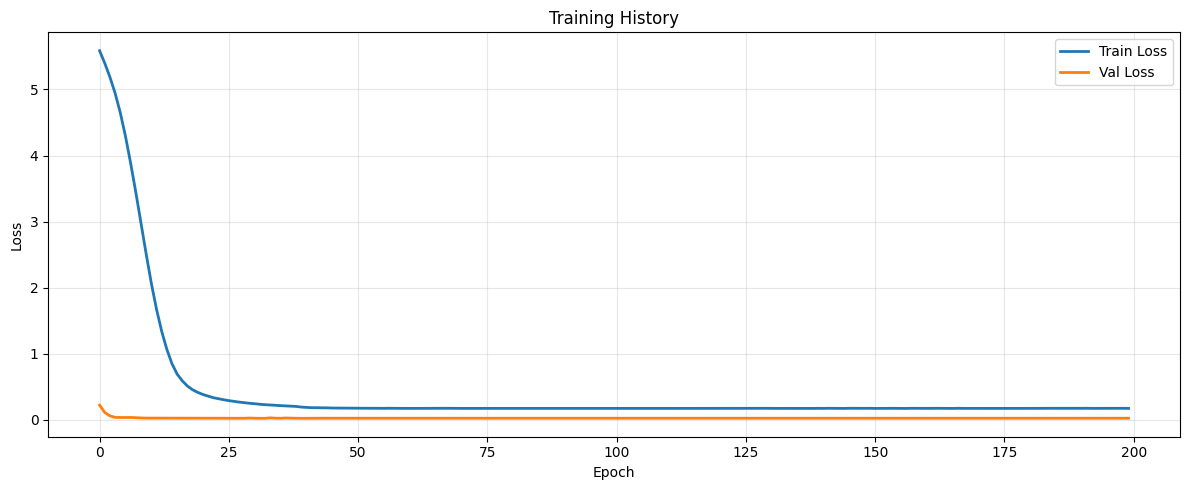

In [20]:
utils.plot_training_history(train_losses, val_losses)


  PLOTTING: disaggregated__num_lag_dummy_seasonal

Training History:


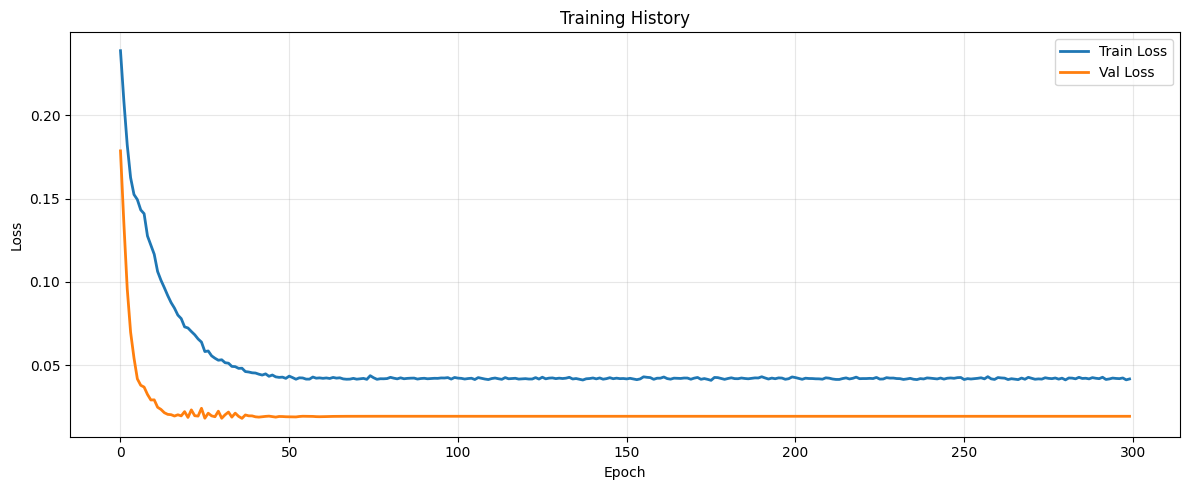


Test Predictions:


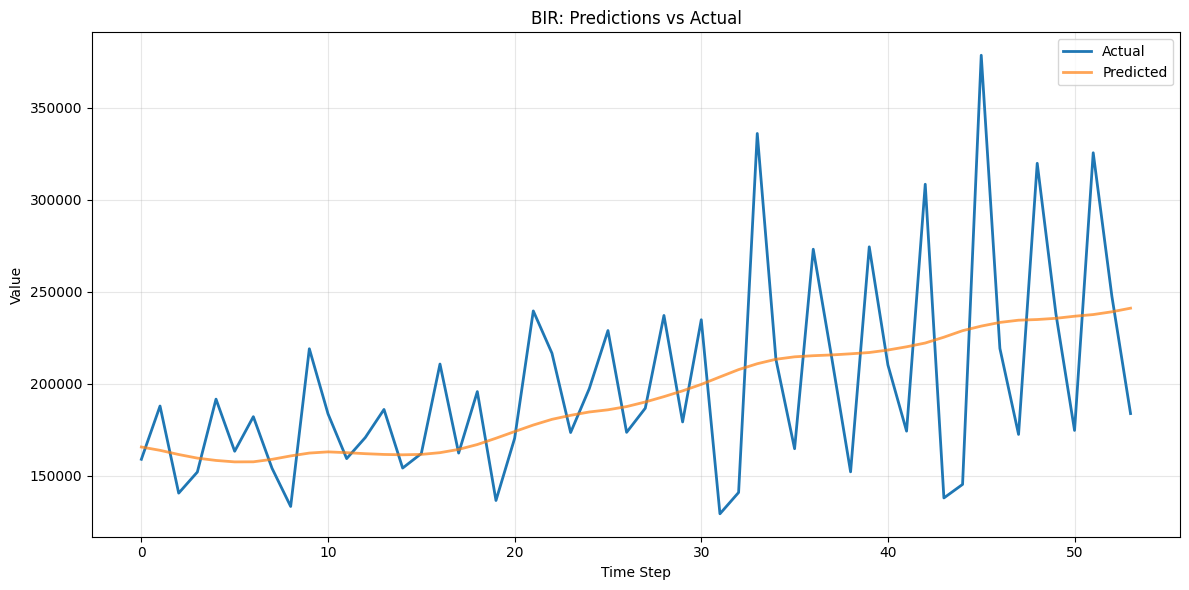

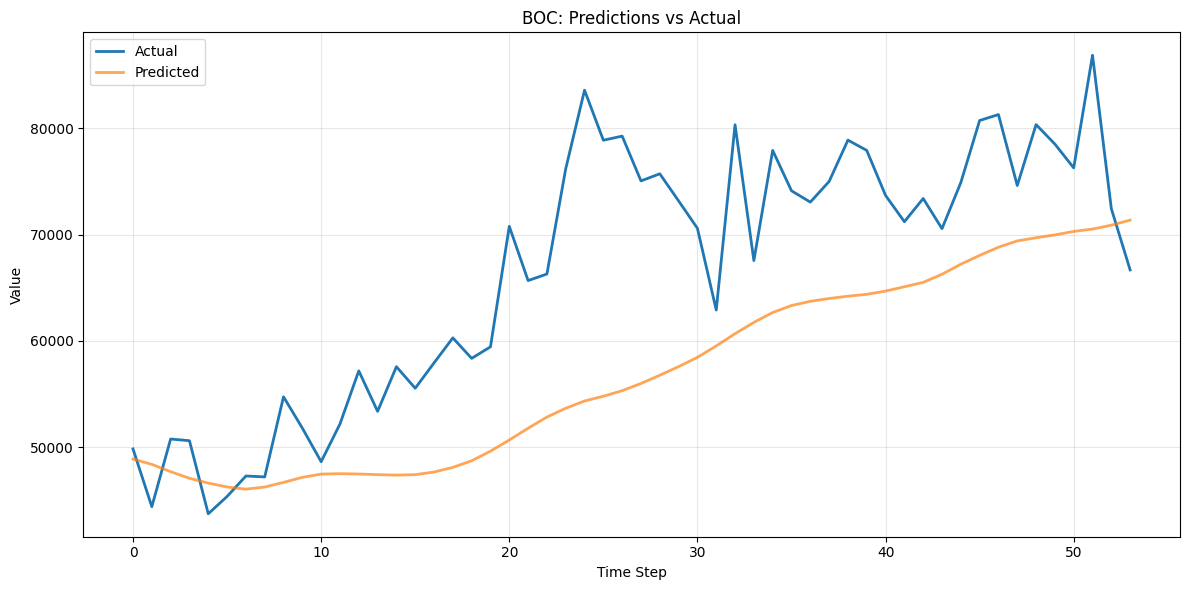

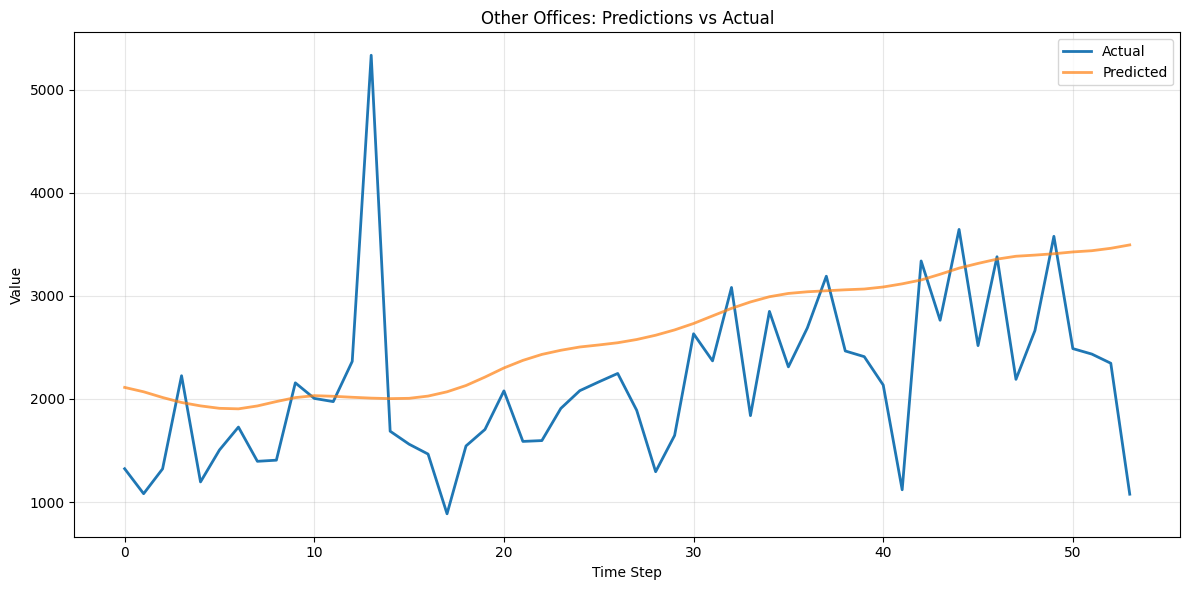

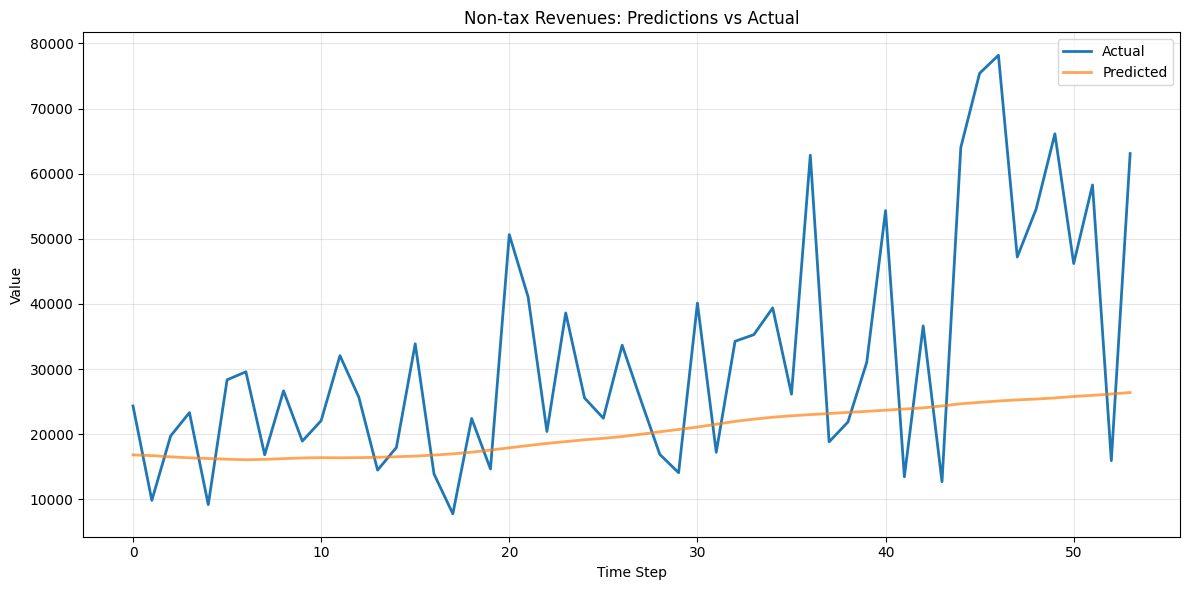

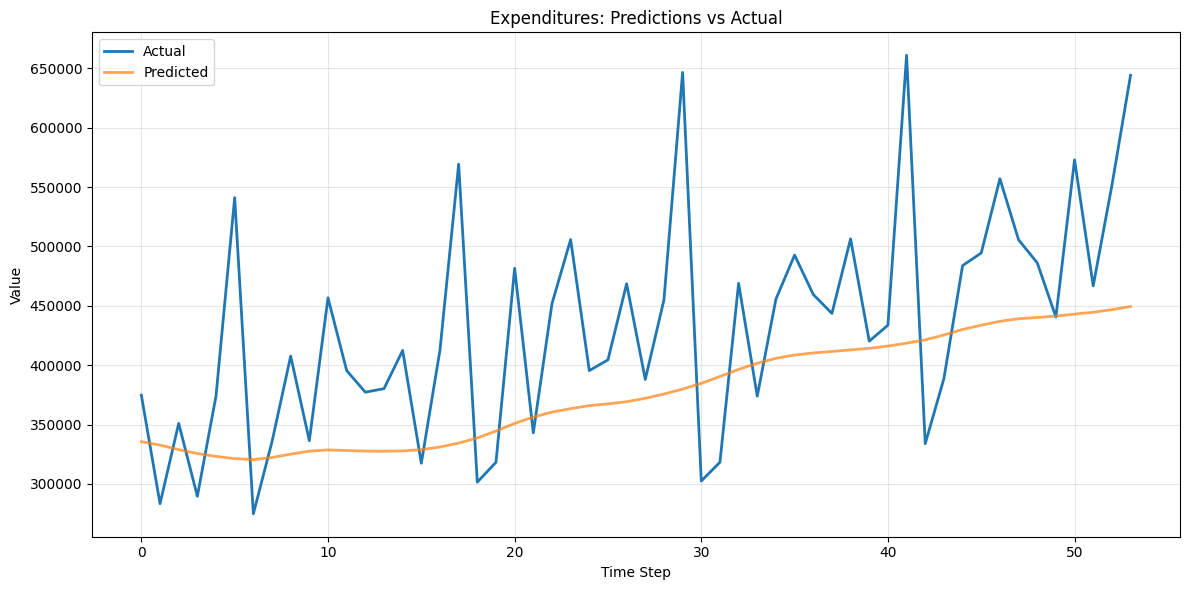

In [3]:
EXPERIMENTS_TO_PLOT = [
   # "aggregated__num_lag_dummy",
   # "aggregated__num_lag_covid",
    #"aggregated__num_lag_dummy_seasonal",
   # "aggregated__num_lag_covid_seasonal",
    #"disaggregated__num_lag_dummy",
    #"disaggregated__num_lag_covid",
    "disaggregated__num_lag_dummy_seasonal",
    #"disaggregated__num_lag_covid_seasonal",
]

for exp_name in EXPERIMENTS_TO_PLOT:
    results_folder = f"results/{exp_name}"
    config_folder = f"configs/{exp_name}"
    
    print(f"\n{'='*60}")
    print(f"  PLOTTING: {exp_name}")
    print(f"{'='*60}")
    
    # Load predictions and losses
    test_preds = np.load(f"{results_folder}/test_predictions.npy")
    train_losses = np.load(f"{results_folder}/train_losses.npy")
    val_losses = np.load(f"{results_folder}/val_losses.npy")
    
    # Load config to get args
    with open(f"{config_folder}/best_config.json", "r") as f:
        best_config = json.load(f)
    
    args = tr.Arguments(**best_config)
    
    # Reconstruct test_loader
    dataset = tr.load_dataset(args)
    final_test_scaled = transform_data(dataset['test_data'], f"Transforms/{exp_name}/test_scaled.pkl")
    final_test_labels_scaled = transform_data(dataset['test_labels'], f"Transforms/{exp_name}/labels_scaled.pkl")
    test_dataset = TimeSeriesDataset(final_test_scaled, final_test_labels_scaled, seq_len=args.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Plot training history
    print("\nTraining History:")
    utils.plot_training_history(train_losses, val_losses)
    
    # Plot predictions
    print("\nTest Predictions:")
    utils.plot_test_predictions(
        test_preds,
        test_loader,
        args,
        scaler_path=f"Transforms/{exp_name}/labels_scaled.pkl"
    )

# SHAP

temporary

not yet checked for correctness


  SHAP ANALYSIS: disaggregated__num_lag_dummy_seasonal


  0%|          | 0/20 [00:00<?, ?it/s]


SHAP Feature Importance (All Outputs):


d:\School\ADMU\M AMF\caps_git\utils.py:153: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(values, test_data, feature_names=feature_names, show=False)
c:\Anaconda\envs\capsenv\Lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Anaconda\envs\capsenv\Lib\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Anaconda\envs\capsenv

<Figure size 1000x800 with 0 Axes>

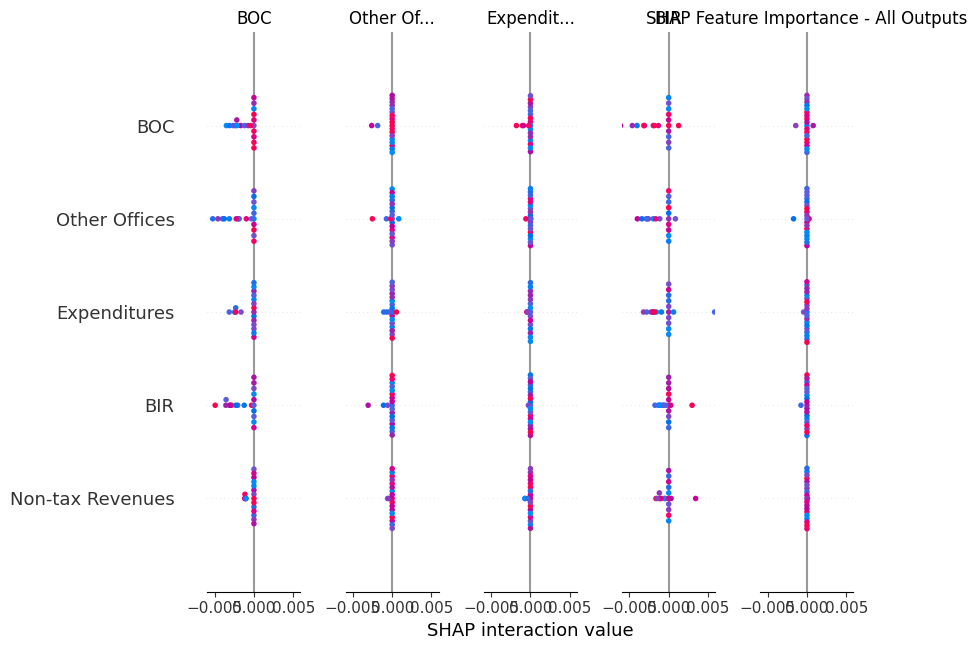


SHAP Mean Importance (All Outputs):


d:\School\ADMU\M AMF\caps_git\utils.py:176: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(values, test_data, feature_names=feature_names, plot_type="bar", show=False)


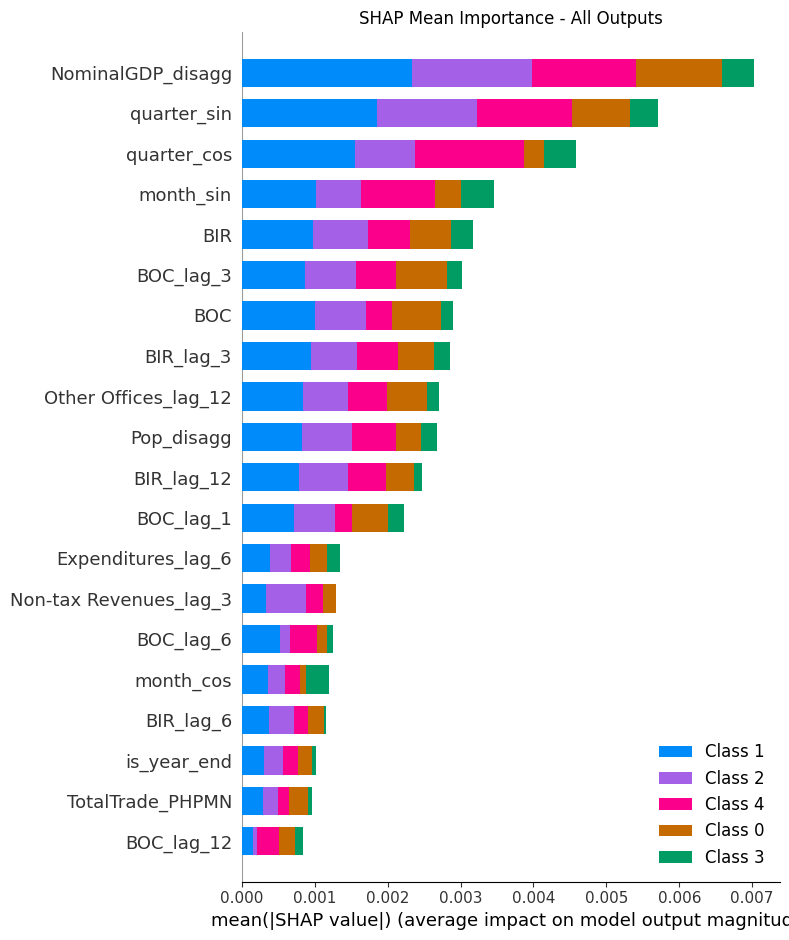


SHAP Waterfall for BIR:


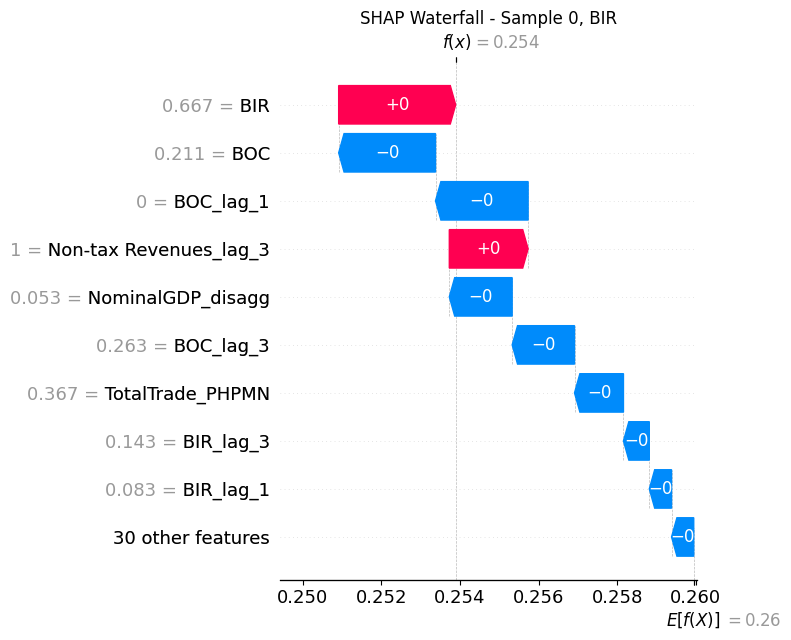


SHAP Waterfall for BOC:


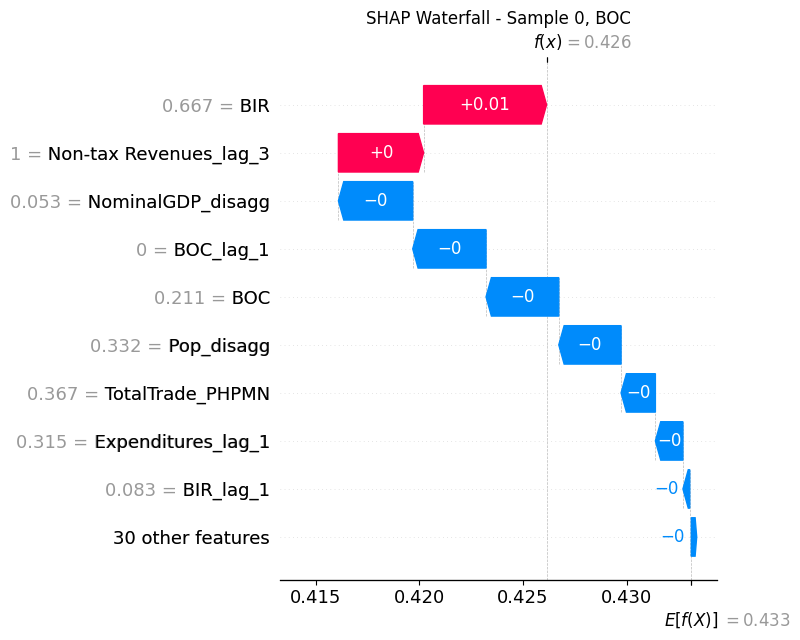


SHAP Waterfall for Other Offices:


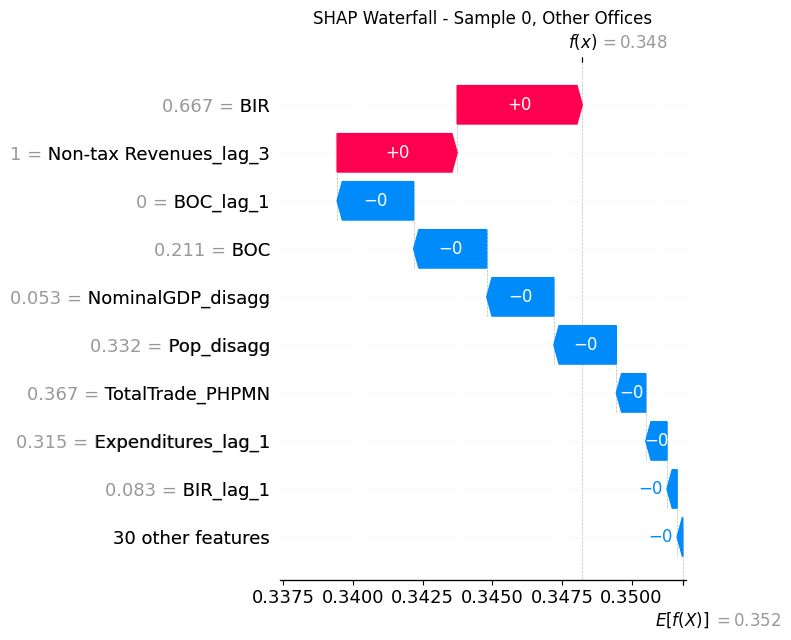


SHAP Waterfall for Non-tax Revenues:


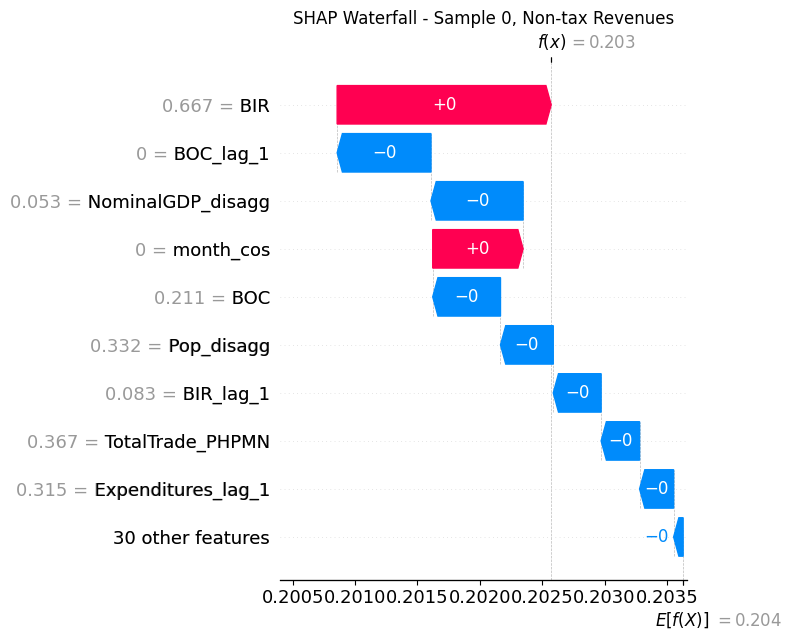


SHAP Waterfall for Expenditures:


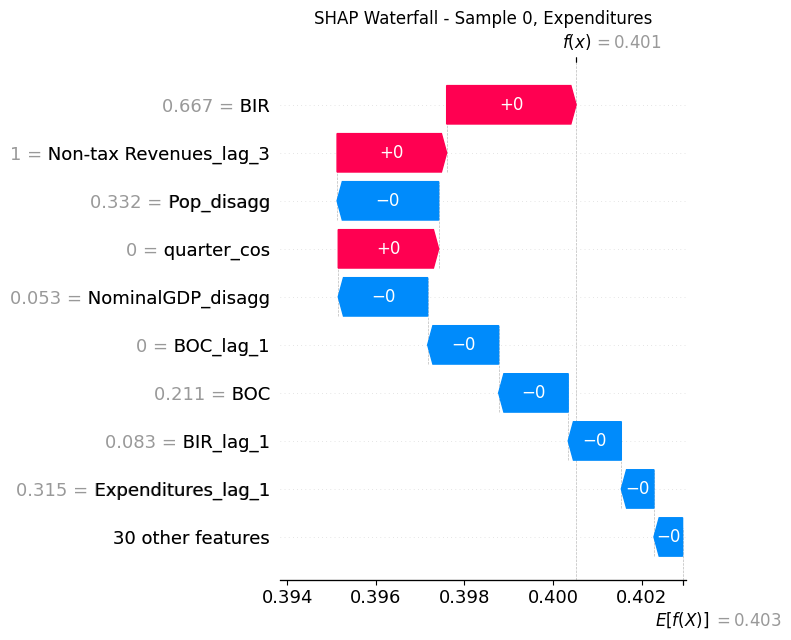

In [2]:
# ============================================================
# SHAP EXPLANATIONS 
# ============================================================

# Specify which experiments to explain
EXPERIMENTS_TO_EXPLAIN = [
    #"aggregated__num_lag_dummy",
    #"aggregated__num_lag_covid",
    #"aggregated__num_lag_dummy_seasonal",
    #"aggregated__num_lag_covid_seasonal",
    #"disaggregated__num_lag_dummy",
    #"disaggregated__num_lag_covid",
    "disaggregated__num_lag_dummy_seasonal",
    #"disaggregated__num_lag_covid_seasonal",
]



for exp_name in EXPERIMENTS_TO_EXPLAIN:
    results_folder = f"results/{exp_name}"
    config_folder = f"configs/{exp_name}"
    
    model_path = f"{results_folder}/final_model.pth"

    print(f"\n{'='*60}")
    print(f"  SHAP ANALYSIS: {exp_name}")
    print(f"{'='*60}")
    
    # Load config
    with open(f"{config_folder}/best_config.json", "r") as f:
        best_config = json.load(f)
    
    args = tr.Arguments(**best_config)
    
    # Set device
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    args.device = device
    
    # Reconstruct dataset and test_loader
    dataset = tr.load_dataset(args)
    final_test_scaled = transform_data(dataset['test_data'], f"Transforms/{exp_name}/test_scaled.pkl")
    final_test_labels_scaled = transform_data(dataset['test_labels'], f"Transforms/{exp_name}/labels_scaled.pkl")
    test_dataset = TimeSeriesDataset(final_test_scaled, final_test_labels_scaled, seq_len=args.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Recreate and load model
    tr.set_seed(1)
    final_model = GRUModel(
        input_size=dataset['input_size'],
        hidden_size=args.hidden_size,
        output_size=dataset['output_size'],
        num_layers=args.num_layers,
        dropout=args.dropout,
        num_attention_heads=getattr(args, 'num_attention_heads', 4),
        args=args
    ).to(device)
    
    final_model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Generate SHAP explanations
    explainer, shap_values, test_data_shap, feature_names = utils.explain_model(
        final_model,
        test_loader,
        args,
        num_samples=50 
    )

    output_names = args.labels if hasattr(args, 'labels') else ['Output']

    print("\nSHAP Feature Importance (All Outputs):")
    utils.plot_shap_summary(shap_values, test_data_shap, feature_names, output_idx=0, output_name="All Outputs")

    print("\nSHAP Mean Importance (All Outputs):")
    utils.plot_shap_bar(shap_values, test_data_shap, feature_names, output_idx=0, output_name="All Outputs")

    for i, output_name in enumerate(output_names):
        print(f"\nSHAP Waterfall for {output_name}:")
        utils.plot_shap_waterfall(explainer, shap_values, test_data_shap, feature_names, sample_idx=0, output_idx=i, output_name=output_name)